In [1229]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u
import pandas as pd
from numpy.random import rand
from math import factorial
import scipy.optimize 
import emcee
import corner
from IPython.display import display, Math
from scipy.optimize import minimize

plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 16})

## McGill Magnetar Catalog:

Determining which magnetars are visible to STARE2 and for how long. This will be used when later working on model corrections that take into account the look-elsewhere effect.

In [497]:
df = pd.read_csv('Data/McGill_magnetar_catalog.csv')

NAMES = df['Name']
RA = df['RA']
DEC = df['Decl']

In [498]:
mags = [SkyCoord(RA[i] + ' ' + DEC[i], unit=(u.hourangle, u.deg)) for i in np.arange(len(RA))]

In [499]:
# Coords for OVRO
LAT, LON, ALT = 37.23, 118.28, 1222
OVRO = EarthLocation(lat=LAT, lon=LON, height=ALT)
FOV = 90-35 # degrees

PST = -7*u.hour
time = Time('2022-8-10 12:00:00') + PST
midnight = Time('2022-8-10 00:00:00') + PST # Change date for today's visability
hours = np.linspace(12, 38, 500)*u.hour
# hours = np.linspace(0, 24, 100)*u.hour

mags_altaz = [mags[i].transform_to(AltAz(obstime=midnight+hours, location=OVRO)) for i in np.arange(len(mags))]

In [500]:
mags_alts = [mags_altaz[i].alt.value for i in np.arange(len(mags_altaz))]
mags_azs = [mags_altaz[i].az.value for i in np.arange(len(mags_altaz))]

In [501]:
len(np.arange(0, len(mags_alts)))

31

In [502]:
SGR1935 = np.argwhere([NAMES[i] == 'SGR 1935+2154' for i in np.arange(len(NAMES))])[0][0]

lws = [1.5]*len(NAMES)
lws[SGR1935] = 5.0


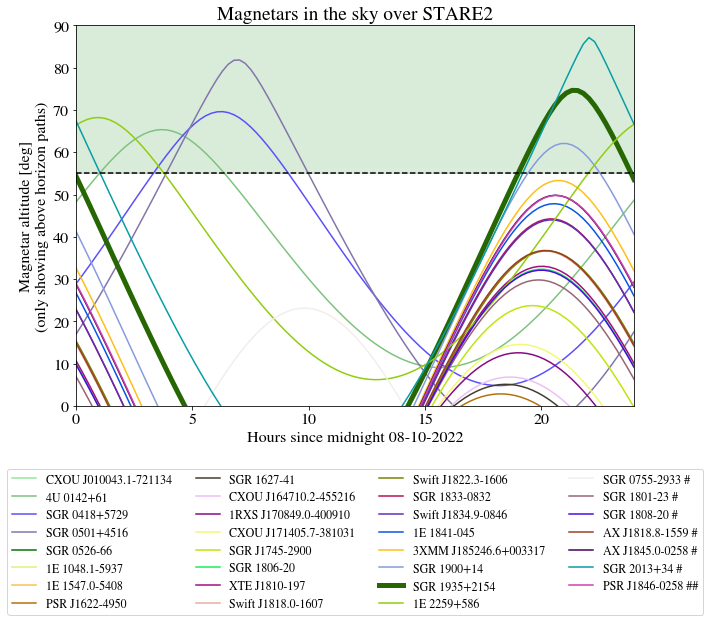

In [79]:
plt.figure(figsize=(10,7))
paths = []
for i in np.arange(0, len(mags_alts)):
    icolor=rand(3)
    path = plt.plot(hours, mags_alts[i], color=icolor, label=NAMES[i], lw=lws[i])
    paths.append(path)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12)
plt.xlabel('Hours since midnight 08-10-2022')
plt.ylabel('Magnetar altitude [deg]\n(only showing above horizon paths)')
plt.margins(x=0, y=0.01)
plt.ylim(0, 90)
plt.title('Magnetars in the sky over STARE2')

horizon = plt.hlines(FOV, min(hours.value), max(hours.value), 'k', linestyles='dashed', label='STARE2 alt. limit', zorder=32)
range = plt.fill_between(hours.value, FOV, 95, zorder=0, alpha=0.15, color='green', label='STARE2 observable')
# paths = np.array(paths)
# legend1 = plt.legend(handles=[paths[i] for i in np.arange(len(paths))], 
#                      loc='upper center', 
#                      bbox_to_anchor=(0.5, -0.15), 
#                      ncol=4, 
#                      fontsize=12)
# plt.gca().add_artist(legend1)
# legend2 = plt.legend(handles=[horizon, range], loc='upper left', bbox_to_anchor=(1,1), fontsize=13)


plt.show();

In [503]:
mag_alts = np.array(mags_alts)
mag_alts.shape

def visible():
    results = []
    for mag in np.arange(len(mag_alts)):
        for i in mag_alts[mag]:
            if i < 55:
                results.append(0)
            elif i > 55:
                results.append(1)
    return results

In [504]:
vis = visible()
vis = np.reshape(vis, (31, 500))

In [505]:
observable_mags = []
nonobservable_mags = []
for i in np.arange(len(vis)):
    if np.any(vis[i]==1):
        observable_mags.append(i)
    elif np.all(vis[i]==0):
        nonobservable_mags.append(i)

In [506]:
print('Number of magnetars observable by STARE2:', len(observable_mags))

Number of magnetars observable by STARE2: 7


In [507]:
print('The magnetars visible to STARE2:\n', NAMES[observable_mags])

The magnetars visible to STARE2:
 1        4U 0142+61
2     SGR 0418+5729
3     SGR 0501+4516
21      SGR 1900+14
22    SGR 1935+2154
23      1E 2259+586
29    SGR 2013+34 #
Name: Name, dtype: object


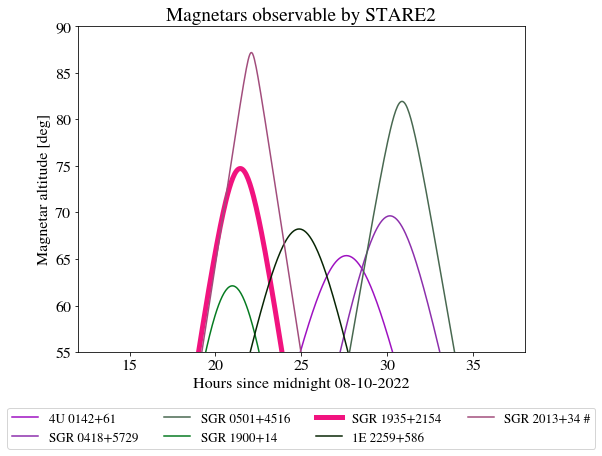

In [508]:
plt.figure(figsize=(8,6))
for i in observable_mags:
    icolor=rand(3)
    plt.plot(hours, mags_alts[i], color=icolor, label=NAMES[i], lw=lws[i])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=13)
plt.xlabel('Hours since midnight 08-10-2022')
plt.ylabel('Magnetar altitude [deg]')
plt.margins(x=0, y=0.01)
plt.ylim(FOV, 90)
plt.title('Magnetars observable by STARE2')

# horizon = plt.hlines(FOV, min(hours.value), max(hours.value), 'k', linestyles='dashed', label='STARE2 alt. limit', zorder=32)
# range = plt.fill_between(hours.value, FOV, 90, zorder=0, alpha=0.15, color='green', label='STARE2 observable')

plt.show();

In [509]:
above_FOV = []

for i in np.arange(len(observable_mags)):
    intercepts = np.array([np.argwhere(mag_alts[observable_mags[i]]>FOV)[0], np.argwhere(mag_alts[observable_mags[i]]>FOV)[-1]])
    above_FOV.append(intercepts)


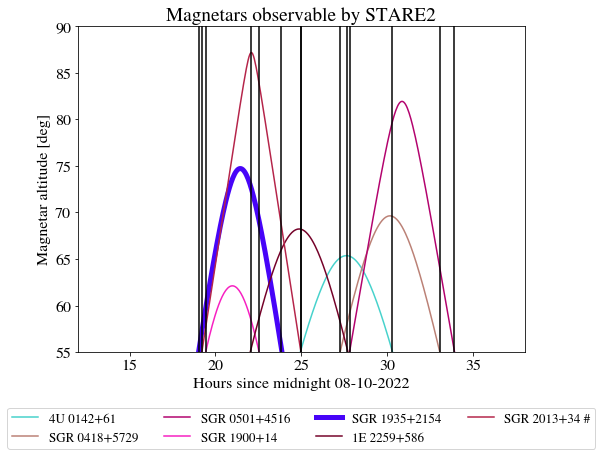

In [510]:
plt.figure(figsize=(8,6))
for i in observable_mags:
    icolor=rand(3)
    plt.plot(hours, mags_alts[i], color=icolor, label=NAMES[i], lw=lws[i])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=13)
plt.xlabel('Hours since midnight 08-10-2022')
plt.ylabel('Magnetar altitude [deg]')
plt.margins(x=0, y=0.01)
plt.ylim(FOV, 90)
plt.title('Magnetars observable by STARE2')
for i in np.arange(len(above_FOV)):
    plt.vlines(hours[above_FOV[i]].value, FOV, 90, 'k')
# plt.vlines(hours[above_FOV[0][0][0]].value, FOV, 90, 'k')
# plt.vlines(hours[above_FOV[1]].value, FOV, 90, 'k')

plt.show();

In [511]:
observable_time = []

for i in np.arange(len(observable_mags)):
    time = np.abs(np.subtract(*hours[above_FOV[i]].value))
    observable_time.append(time)
observable_time # hours/day

[array([5.31462926]),
 array([5.78356713]),
 array([6.04408818]),
 array([3.0741483]),
 array([4.79358717]),
 array([5.62725451]),
 array([5.73146293])]

## Poisson analysis

### STARE2

In [512]:
def λ(r, t):
    return r*t

R_STARE2 = 4.19 # yr^-1 --- MJy ms fluence FRB rate from SGR1935 (computed in 'rates_vs_fluence_estimates.ipynb')
t_obs = 2090.667 # hrs -- total obs. time (computed in 'rates_vs_fluence_estimates.ipynb')
T_STARE2 = (t_obs/(24))*np.sum(observable_time) # hrs
print(T_STARE2)

λ_STARE2 = λ(R_STARE2, T_STARE2)/8760 # divide by hrs/yr
λ_STARE2 # unitless

3168.121636272545


1.5153458511394937

In [513]:
from scipy.stats import poisson

ks_STARE2 = np.arange(0, 11)
dist_STARE2 = poisson.pmf(ks_STARE2, mu=λ_STARE2)

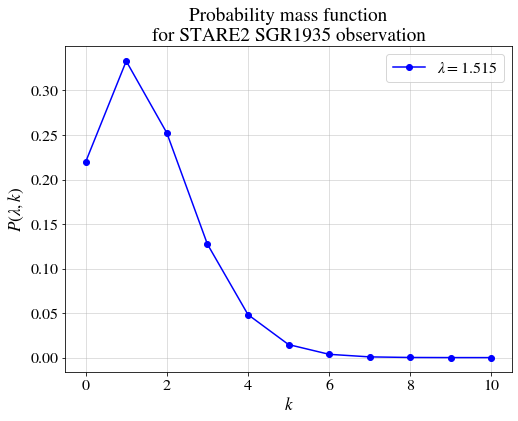

In [514]:
plt.figure(figsize=(8,6))
plt.plot(ks_STARE2, dist_STARE2, 'bo-', label='$λ = {0:.3f}$'.format(λ_STARE2))
plt.title('Probability mass function\nfor STARE2 SGR1935 observation')
plt.ylabel('$P(λ, k)$', fontsize=17)
plt.xlabel('$k$', fontsize=17)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

### Kirsten et al.

In [515]:
T_euro = 522.7 # hrs
R_euro = 33.5 # yr^-1 --- Jy ms rate from SGR1935 (computed in 'rates_vs_fluence_estimates.ipynb')

λ_euro = λ(R_euro, T_euro)/8760 # divide by hrs/yr
λ_euro # unitless

1.9989098173515982

In [516]:
ks_euro = np.arange(0, 11)
dist_euro = poisson.pmf(ks_euro, mu=λ_euro)

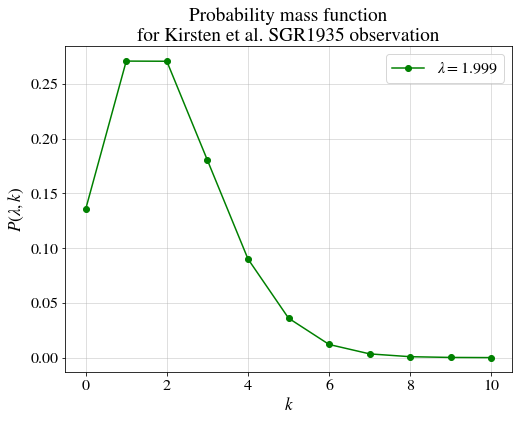

In [517]:
plt.figure(figsize=(8,6))
plt.plot(ks_euro, dist_euro, 'go-', label='$λ = {0:.3f}$'.format(λ_euro))
plt.title('Probability mass function\nfor Kirsten et al. SGR1935 observation')
plt.ylabel('$P(λ, k)$', fontsize=17)
plt.xlabel('$k$', fontsize=17)
plt.legend()
plt.grid(alpha=0.5)

<Figure size 432x288 with 0 Axes>

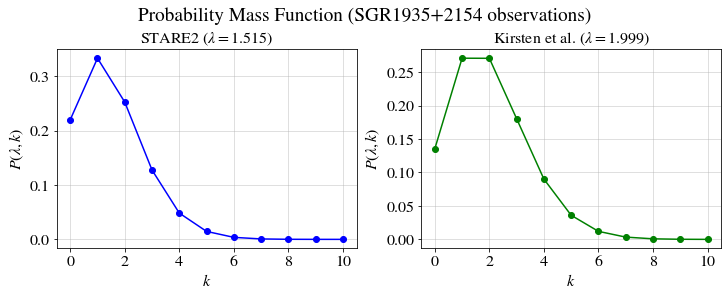

In [518]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
ax0.plot(ks_STARE2, dist_STARE2, 'bo-')
ax1.plot(ks_euro, dist_euro, 'go-')
ax0.set_ylabel('$P(λ, k)$', fontsize=16)
ax1.set_ylabel('$P(λ, k)$', fontsize=16)
ax0.set_xlabel('$k$', fontsize=16)
ax1.set_xlabel('$k$', fontsize=16)
ax0.grid(alpha=0.5), ax1.grid(alpha=0.5)
plt.suptitle('Probability Mass Function (SGR1935+2154 observations)')

ax0.set_title('STARE2 ($λ = {0:.3f}$)'.format(λ_STARE2), fontsize=16)
ax1.set_title('Kirsten et al. ($λ = {0:.3f}$)'.format(λ_euro), fontsize=16)

plt.show()

In [519]:
σ_STARE2 = np.sqrt(λ_STARE2)
σ_euro = np.sqrt(λ_euro)

print('STARE2 STD:', σ_STARE2, '\nKirsten et al. STD:', σ_euro)

STARE2 STD: 1.2309938469137423 
Kirsten et al. STD: 1.4138280720623702


<Figure size 432x288 with 0 Axes>

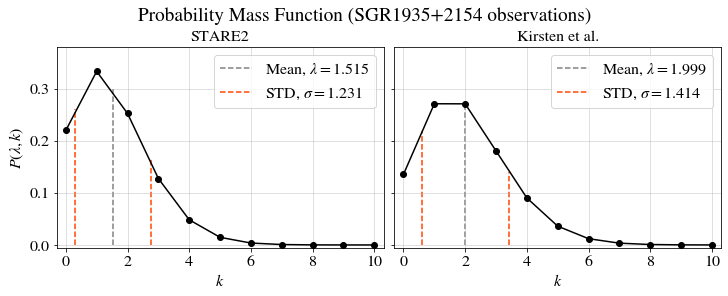

In [520]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True, sharey=True)
ax0.plot(ks_STARE2, dist_STARE2, 'ko-')
ax1.plot(ks_euro, dist_euro, 'ko-')
ax0.set_ylabel('$P(λ, k)$', fontsize=16)
# ax1.set_ylabel('$P(λ, k)$', fontsize=16)
ax0.set_xlabel('$k$', fontsize=16)
ax1.set_xlabel('$k$', fontsize=16)
ax0.grid(alpha=0.5), ax1.grid(alpha=0.5)
plt.suptitle('Probability Mass Function (SGR1935+2154 observations)')

ax0.set_title('STARE2', fontsize=16)
ax1.set_title('Kirsten et al.', fontsize=16)

ax0.vlines(λ_STARE2, 0, 0.30, 'grey', linestyles='dashed', label='Mean, $λ={0:.3f}$'.format(λ_STARE2), zorder=1)
ax0.vlines(λ_STARE2-σ_STARE2, 0, 0.26, 'orangered', linestyles='dashed', label='STD, $σ={0:.3f}$'.format(σ_STARE2), zorder=1)
ax0.vlines(λ_STARE2+σ_STARE2, 0, 0.165, 'orangered', linestyles='dashed', zorder=1)
ax0.legend()

ax1.vlines(λ_euro, 0, 0.27, 'grey', linestyles='dashed', label='Mean, $λ={0:.3f}$'.format(λ_euro), zorder=1)
ax1.vlines(λ_euro-σ_euro, 0, 0.218, 'orangered', linestyles='dashed', label='STD, $σ={0:.3f}$'.format(σ_euro), zorder=1)
ax1.vlines(λ_euro+σ_euro, 0, 0.14, 'orangered', linestyles='dashed', zorder=1)
ax1.legend()

ax0.margins(y=0.02, x=0.03)
ax1.margins(y=0.02, x=0.03)

ax0.set_ylim(top=0.38)
# ax1.set_ylim(top=0.40)
plt.show()

### Make a function of rate (R)

In [521]:
R_range_STARE2 = np.linspace(0, 25, 1000)
R_range_euro = np.linspace(0, 200, 1000)

T_STARE2_yrs = T_STARE2/8760
T_euro_yrs = T_euro/8760

print(T_STARE2_yrs, T_euro_yrs)

0.36165772103567867 0.0596689497716895


Normalization constants A were determined by solving the following integral for each observation (STARE2 and Kirsten et al.):
$1 = \int_0^\infty A P(R)dR$

Furthermore, the median was manually solved for by solving the following integral:
$\frac{1}{2} = \int_{R_{med}}^\infty A P(R)dR$

In [522]:
# Normalization constants -- UNITLESS
A_STARE2 = T_STARE2_yrs
A_euro = T_euro_yrs 

# Median values
R_median_STARE2 = 4.641
R_median_euro = 44.815

k_STARE2 = 1
k_euro = 2

In [523]:
def P(A, R, T, k):
    a = (R*T)**k
    b = np.exp(-R*T)
    c = factorial(k)
    return A*(a*b)/c

prob_dist_STARE2 = P(A_STARE2, R_range_STARE2, T_STARE2_yrs, k_STARE2)
prob_dist_euro = P(A_euro, R_range_euro, T_euro_yrs, k_euro)

The standard deviation ($1\sigma$) is computed by integrating to 16% and 84% for the lower and upper bounds.

$0.16 = \int_{R_{med}}^\infty A P(R)dR$

$0.84 = \int_{R_{med}}^\infty A P(R)dR$

Once again, these integrals are solved numerically.

In [524]:
# 1σ  R values
minus_std_STARE2 = 1.969
plus_std_STARE2 = 9.093

minus_std_euro = 23.009
plus_std_euro = 77.511


# 1σ values
plus_1σ_STARE2 = plus_std_STARE2 - R_median_STARE2 
minus_1σ_STARE2 = R_median_STARE2 - minus_std_STARE2

plus_1σ_euro = plus_std_euro - R_median_euro
minus_1σ_euro = R_median_euro - minus_std_euro

<Figure size 432x288 with 0 Axes>

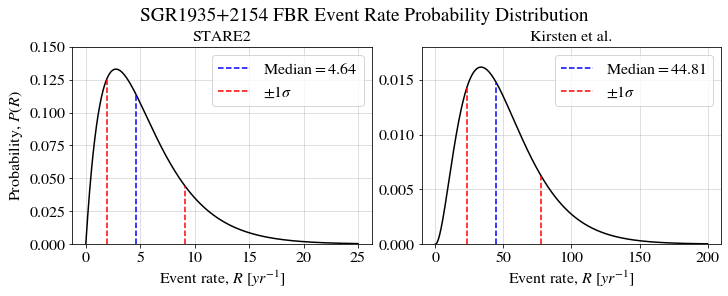

In [525]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True, sharey=False)
ax0.plot(R_range_STARE2, prob_dist_STARE2, 'k-')
ax1.plot(R_range_euro, prob_dist_euro, 'k-')

ax0.set_ylabel('Probability, $P(R)$', fontsize=16)

ax0.set_xlabel('Event rate, $R$ $[yr^{-1}]$', fontsize=16)
ax1.set_xlabel('Event rate, $R$ $[yr^{-1}]$', fontsize=16)

ax0.grid(alpha=0.5), ax1.grid(alpha=0.5)
plt.suptitle('SGR1935+2154 FBR Event Rate Probability Distribution')

ax0.set_title('STARE2', fontsize=16)
ax1.set_title('Kirsten et al.', fontsize=16)

ax0.vlines(R_median_STARE2, 0, P(A_STARE2, R_median_STARE2, T_STARE2_yrs, k_STARE2), color='blue', linestyles='dashed', zorder=3, label='Median$ = {0:.2f}$'.format(R_median_STARE2))
ax0.vlines(plus_std_STARE2, 0, P(A_STARE2, plus_std_STARE2, T_STARE2_yrs, k_STARE2), color='red', linestyles='dashed', zorder=3, label='$\pm1σ$')
ax0.vlines(minus_std_STARE2, 0, P(A_STARE2, minus_std_STARE2, T_STARE2_yrs, k_STARE2), color='red', linestyles='dashed', zorder=3)

ax1.vlines(R_median_euro, 0, P(A_euro, R_median_euro, T_euro_yrs, k_euro), color='blue', linestyles='dashed', zorder=3, label='Median$ = {0:.2f}$'.format(R_median_euro))
ax1.vlines(plus_std_euro, 0, P(A_euro, plus_std_euro, T_euro_yrs, k_euro), color='red', linestyles='dashed', zorder=3, label='$\pm1σ$')
ax1.vlines(minus_std_euro, 0, P(A_euro, minus_std_euro, T_euro_yrs, k_euro), color='red', linestyles='dashed', zorder=3)

ax0.legend()
ax1.legend()

ax0.margins(y=0)
ax0.set_ylim(top=0.15)
ax1.margins(y=0)
ax1.set_ylim(top=0.018)

plt.show()

## Rate vs. Fluences

### Without the look-elsewhere effect:

Reproduced from 'rates_vs_fluence_estimates.ipynb'.

In [526]:
STARE2_FWHM = 70 # degrees

STARE2_SGR1935_time = (STARE2_FWHM/360)*24 # hr/day

STARE2_obs_days = 448 # days

STARE2_tot_obs_time = STARE2_SGR1935_time*STARE2_obs_days # hrs
print('Total obs time of SGR1935 by STARE2:', STARE2_tot_obs_time)

Total obs time of SGR1935 by STARE2: 2090.666666666667


In [527]:
annual_hours = 8760 # hrs/year
MJy_rate = annual_hours/STARE2_tot_obs_time

print('MJy ms fluence FRB rate from SGR1935:', MJy_rate)

MJy ms fluence FRB rate from SGR1935: 4.190051020408163


In [528]:
# # Obs. data
# obs_rate_pnts = [33.5, 4.19]
# obs_fluence_pnts = np.log10([1e2, 1.5e6])

In [529]:
# def exp_model(x, A, b):
#     return A*10**(b*x)

# guesses = np.array([1, -.01])
# opt, cov = scipy.optimize.curve_fit(exp_model, obs_fluence_pnts, obs_rate_pnts, guesses) 
# # print('A, b = {param:.3f}'.format(param=opt))
# print('A, b = {0:.3f}, {1:.3f}'.format(opt[0], opt[1]));

In [530]:
# plt.figure(figsize=(7,5))

# plt.title('OLD MODEL')

# obs_labels = ['Kirsten et al. (2021)', 'CHIME + STARE2 (2020)']
# obs_markers = ['s', '^']
# for i in np.arange(len(obs_rate_pnts)):
#     plt.semilogy(obs_fluence_pnts[i], obs_rate_pnts[i], 'k', marker=obs_markers[i], 
#              label=obs_labels[i], markersize=8, linestyle='None')
# xs = np.linspace(*np.log10([1e0, 1e7])) 
# plt.plot(xs, exp_model(xs, *opt), 'b--', zorder=1, 
#          label='Model: $y=A\cdot10^{Bx}$'+'\n[A, B] = [{0:.3f}, {1:.3f}]'.format(opt[0], opt[1]))

# plt.xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
# plt.ylabel('FRB event rate,\nR($>\mathcal{F}$)  [yr$^{-1}$]')

# plt.plot(3, exp_model(3, *opt), marker='*', markersize=13, c='orangered', label='kJy$\cdot$ms FRB', linestyle='None')

# plt.legend(bbox_to_anchor=(1,1), loc='upper left')
# plt.grid()

# plt.show()

### With the look-elsewhere effect:

In [531]:
obs_rate_LEE = np.log10([R_median_euro, R_median_STARE2])
obs_fluence_pnts = np.log10([1e2, 1.5e6])
# sigmas = np.log10([[minus_1σ_euro, plus_1σ_euro], [minus_1σ_STARE2, plus_1σ_STARE2]])
rate_err = [np.log10([R_median_euro+plus_1σ_euro, R_median_euro-minus_1σ_euro]), np.log10([R_median_STARE2+plus_1σ_STARE2, R_median_STARE2-minus_1σ_STARE2])]
pm_err = [np.abs(obs_rate_LEE[i]-rate_err[i]) for i in range(2)]
np.array(pm_err).T

array([[0.23793994, 0.29209562],
       [0.28952566, 0.37236585]])

In [532]:
# # guesses = np.array([1, -.01])
# opt_new, cov_new = scipy.optimize.curve_fit(exp_model, obs_fluence_pnts, obs_rate_LEE, guesses) 
# # print('A, b = {param:.3f}'.format(param=opt))
# print('A, b = {0:.3f}, {1:.3f}'.format(opt_new[0], opt_new[1]));

In [533]:
# ## Comparing previous model to new model ##
# plt.figure(figsize=(7,5))

# plt.title('COMPARING NEW MODEL TO OLD MODEL')

# obs_labels = ['Kirsten et al. (2021)', 'STARE2 (2020)']
# obs_markers = ['s', '^']
# for i in np.arange(len(obs_rate_LEE)):
#     plt.errorbar(obs_fluence_pnts[i], obs_rate_LEE[i], yerr=np.array([rate_err[i]]).T, color='k', capsize=3,
#                  marker=obs_markers[i], label=obs_labels[i], markersize=8, linestyle='None')
#     plt.semilogy(obs_fluence_pnts[i], obs_rate_pnts[i], color='grey', marker=obs_markers[i],
#                  markersize=8, linestyle='None', alpha=0.6)
# xs = np.linspace(*np.log10([1e0, 1e7])) 
# plt.plot(xs, exp_model(xs, *opt), color='grey', linestyle='--', alpha=0.6, zorder=1)
# plt.plot(xs, exp_model(xs, *opt_new), color='blue', linestyle='dashed', zorder=1, 
#         label='Model: $y=A\cdot10^{Bx}$'+'\n[A, B] = [{0:.3f}, {1:.3f}]'.format(opt_new[0], opt_new[1]))

# plt.xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
# plt.ylabel('FRB event rate,\nR($>\mathcal{F}$)  [yr$^{-1}$]')

# # plt.plot(3, exp_model(3, *opt), marker='*', markersize=13, color='gold', linestyle='None', alpha=0.6)
# plt.plot(3, exp_model(3, *opt_new), marker='*', markersize=13, color='orangered', linestyle='None', label='kJ$\cdot$ms target FRB')

# plt.legend(bbox_to_anchor=(1,1), loc='upper left')
# # plt.grid()

# plt.show()

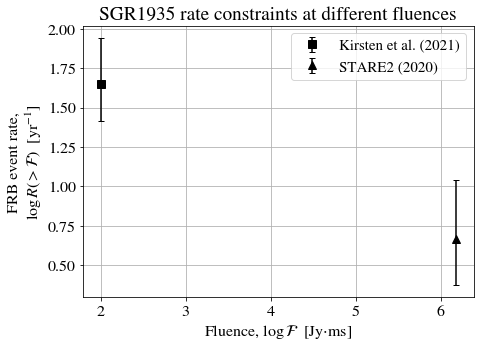

In [813]:
### Can't plot best fit line just yet -- above BFL was for visual reference ###

plt.figure(figsize=(7,5))

plt.title('SGR1935 rate constraints at different fluences')

obs_labels = ['Kirsten et al. (2021)', 'STARE2 (2020)']
obs_markers = ['s', '^']
for i in range(2):
    plt.errorbar(obs_fluence_pnts[i], obs_rate_LEE[i], yerr=np.array([pm_err[i]]).T, color='k', capsize=3,
                 marker=obs_markers[i], label=obs_labels[i], markersize=8, linestyle='None')
# plt.yscale('log')

# plt.plot(obs_fluence_pnts[0], obs_rate_LEE[0], 'ko')
# plt.plot(obs_fluence_pnts[0], obs_rate_LEE[0]+plus_1σ_euro, 'k.')

# plt.ylim(top=2e2)
# plt.xlim(left=1, right=7)

# plt.plot(np.linspace(0,7), -0.361*np.linspace(0,7)+0.906)
plt.xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
plt.ylabel('FRB event rate,\n$\log{R(>\mathcal{F}}$)  [yr$^{-1}$]')

plt.legend(loc='upper right', fontsize=15)
plt.grid()

plt.show()

[-0.23582143  2.12306627] [[ 0.11468062 -0.46881961]
 [-0.46881961  2.41655594]]


(array([-0.23582143,  2.12306627]),
 array([[0.00179214, 0.00876835],
        [0.00876835, 0.19569798]]))

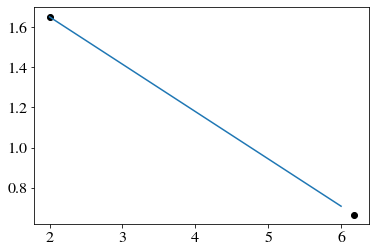

In [1410]:
### Simple best fit line -- nonweighted ###
guesses = np.array([-.25, 2])
def model(x, m, b):
    y = m*x + b
    return y

pop, cov = scipy.optimize.curve_fit(model, F_meds, R_meds, guesses, absolute_sigma=True)
print(pop, cov)

plt.plot(F_meds, R_meds, 'ko')
plt.plot(np.arange(F_meds[0], F_meds[1]), model(np.arange(F_meds[0], F_meds[1]), *pop))
# plt.plot(F_meds, R_means, 'r.')

popt, covt = scipy.optimize.curve_fit(model, F_meds, R_meds, guesses, sigma=np.array(pm_err).T, absolute_sigma=True)
popt, covt

## MCMC

Reference: https://emcee.readthedocs.io/en/stable/tutorials/line/

In [1316]:
# # Compute the mean of the above probability distributions
# euro_args = np.argwhere(np.isclose(prob_dist_euro, np.mean(prob_dist_euro), atol=1e-4)==True)
# print(euro_args)
# R_euro_mean = R_range_euro[417]
# print(R_euro_mean, prob_dist_euro[417], np.mean(prob_dist_euro))

# STARE2_args = np.argwhere(np.isclose(prob_dist_STARE2, np.mean(prob_dist_STARE2), atol=1e-5)==True)
# print(STARE2_args)
# R_STARE2_mean = R_range_STARE2[380]
# R_STARE2_mean
# print(R_STARE2_mean, prob_dist_STARE2[380], np.mean(prob_dist_STARE2))

In [1317]:
### [EURO, STARE2]
R_meds = np.log10([R_median_euro, R_median_STARE2])
F_meds = np.log10([1e2, 1.5e6])
R_means = np.log10([R_euro_mean, R_STARE2_mean])
# print((R_meds-R_means)**2)

# λs = np.array([λ_euro, λ_STARE2])
ks = np.array([float(k_euro), float(k_STARE2)])
λs = np.array([R_median_euro*T_euro_yrs, R_median_STARE2*T_STARE2_yrs])

# plt.plot(F_meds, R_meds, 'ko')

In [1318]:
# def log_likelihood(theta, R, F, yerr): # Gaussian likelihood
#     m, b = theta
#     model = m*R + b
#     sigma2 = (yerr)**2
#     L = -0.5*np.sum((F-model)**2/sigma2 + np.log(sigma2))
#     return L

def log_likelihood(pars, D, F): # Poisson likelihood
    m, b = pars
    theta = F*m + b
    P = (theta**D * np.exp(-theta)) / D
    return np.sum(np.log(P))

In [1319]:
nll = lambda *args: -log_likelihood(*args) 
# maximizing the likelihood is the same as minimizing the negative of the liklihood

initial = np.array([-0.25, 2])
soln = minimize(nll, initial, args=(ks, F_meds))
m_ml, b_ml = soln.x # maximum likelihood values

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))

Maximum likelihood estimates:
m = -0.239
b = 2.479


In [1368]:
def log_prior(pars): # sets up priors on theta
    m, b = pars
    if -2 < m < 1 and -1 < b < 8:
        return 0.0
    return -np.inf

In [1369]:
def log_probability(pars, D, F):
    lp = log_prior(pars) 
    if not np.isfinite(lp): 
        return -np.inf
    if np.isnan(lp + log_likelihood(pars, D, F)):
        return -np.inf
    return lp + log_likelihood(pars, D, F)

In [1370]:
pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim, 
                                log_probability, 
                                args=(ks, F_meds))

sampler.run_mcmc(pos, 50000, progress=True);

  0%|                         | 20/50000 [00:00<04:10, 199.89it/s]/tmp/ipykernel_1128/4274819237.py:12: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(P))
100%|██████████████████████| 50000/50000 [02:44<00:00, 304.25it/s]


In [1371]:
samples = sampler.get_chain()

tau = sampler.get_autocorr_time()
print('Integrated autocorrelation time:', tau)

Integrated autocorrelation time: [36.30425369 35.46689025]


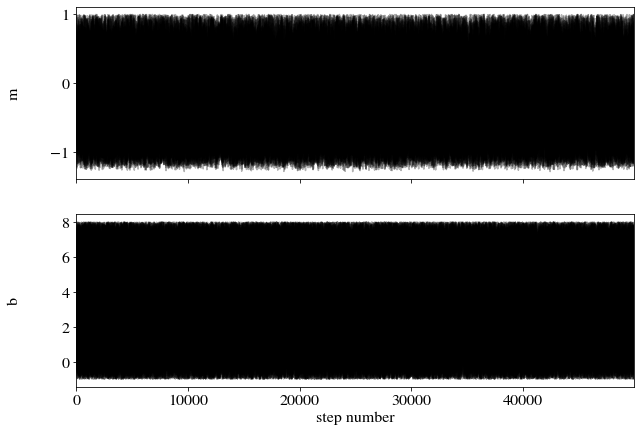

In [1372]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ['m', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples)-1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('step number');

In [1373]:
flat_samples = sampler.get_chain(discard=120, thin=20, flat=True)
print(flat_samples.shape)

(79808, 2)


In [1374]:
ms, bs = flat_samples[:, 0], flat_samples[:, 1]

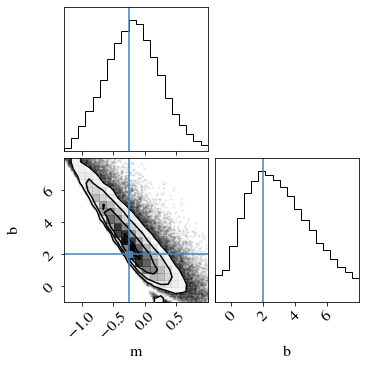

In [1408]:
fig = corner.corner(flat_samples, labels=labels, truths=initial)

corner.corner?

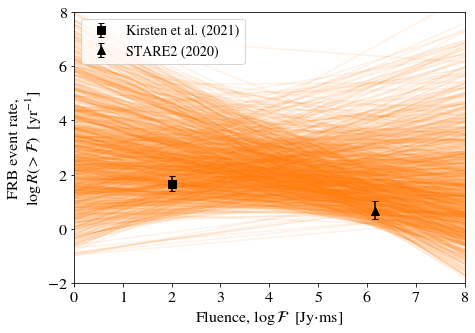

In [1376]:
x0 = np.linspace(0, 10, 500)

plt.figure(figsize=(7,5))
inds = np.random.randint(len(flat_samples), size=1000)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
obs_labels = ['Kirsten et al. (2021)', 'STARE2 (2020)']
obs_markers = ['s', '^']
for i in range(2):
    plt.errorbar(F_meds[i], R_meds[i], yerr=np.array([pm_err[i]]).T, color='k', capsize=3,
                 marker=obs_markers[i], label=obs_labels[i], markersize=8, linestyle='None')
# plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14, loc='upper left')
plt.xlim(0, 8)
plt.ylim(-2, 8)
plt.xlabel('Fluence, $\mathcal{\log{F}}$  [Jy$\cdot$ms]')
plt.ylabel('FRB event rate,\n$\log{R(>\mathcal{F}}$)  [yr$^{-1}$]')
plt.show()

<Figure size 432x288 with 0 Axes>

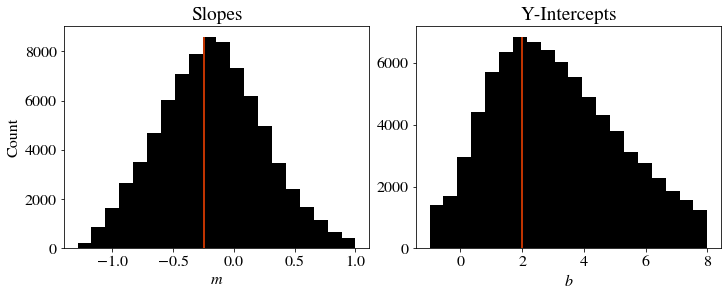

In [1425]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True, sharey=False)

ax0.hist(ms, bins=20, color='k', alpha=1)
ax1.hist(bs, bins=20, color='k', alpha=1)
ax0.set_title('Slopes')
ax1.set_title('Y-Intercepts')
ax0.set_ylabel('Count')
ax0.set_xlabel('$m$')
ax1.set_xlabel('$b$')

hist_ms = np.histogram(ms, bins=20)
hist_bs = np.histogram(bs, bins=20)
ax0.vlines(initial[0], 0, np.max(hist_ms[0]), color='orangered')
ax1.vlines(initial[1], 0, np.max(hist_bs[0]), color='orangered')
plt.show()

### orange line is max likelihood values


In [1426]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [1486]:
m_16, m_50, m_84 = np.percentile(ms, [16, 50, 84])
m_mcmc = np.array([m_16, m_50, m_84])
m_qs = np.diff(m_mcmc)

b_16, b_50, b_84 = np.percentile(bs, [16, 50, 84])
b_mcmc = np.array([b_16, b_50, b_84])
b_qs = np.diff(b_mcmc)

<Figure size 432x288 with 0 Axes>

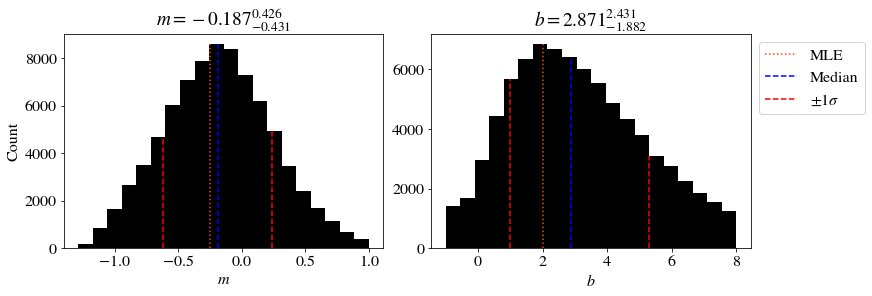

In [1495]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True, sharey=False)

ax0.hist(ms, bins=20, color='k', alpha=1)
ax1.hist(bs, bins=20, color='k', alpha=1)
# txt = "{0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
# txt_m = txt.format(m_50, m_qs[0], m_qs[1])
# print(txt)
ax0.set_title('$m = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$'.format(m_50, m_qs[0], m_qs[1]))
ax1.set_title('$b = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$'.format(b_50, b_qs[0], b_qs[1]))
ax0.set_ylabel('Count')
ax0.set_xlabel('$m$')
ax1.set_xlabel('$b$')

hist_ms = np.histogram(ms, bins=20)
hist_bs = np.histogram(bs, bins=20)
ax0.vlines(initial[0], 0, np.max(hist_ms[0]), color='orangered', linestyles='dotted', alpha=1)
ax1.vlines(initial[1], 0, np.max(hist_bs[0]), color='orangered', linestyles='dotted', alpha=1, label='MLE')

ax0.vlines(m_50, 0, hist_ms[0][9], color='blue', linestyles='dashed')
ax0.vlines(m_16, 0, hist_ms[0][5], color='red', linestyles='dashed')
ax0.vlines(m_84, 0, hist_ms[0][13], color='red', linestyles='dashed')

ax1.vlines(b_50, 0, hist_bs[0][8], color='blue', linestyles='dashed', label='Median')
ax1.vlines(b_16, 0, hist_bs[0][4], color='red', linestyles='dashed', label='$\pm 1σ$')
ax1.vlines(b_84, 0, hist_bs[0][14], color='red', linestyles='dashed')

ax1.legend(bbox_to_anchor=(1,1), loc='upper left')

plt.show()



#### Checking the validity of MCMC runs by constructing fake data and confirming the output with expectations

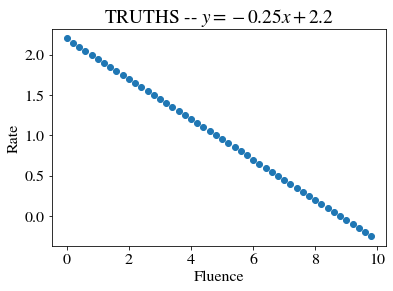

In [1274]:
m_truth = -0.25
b_truth = 2.2
 
fluences_truth = np.arange(0, 10, 0.2)

def rates_model(fluence):
    return m_truth*fluence + b_truth

rates_truth = rates_model(fluences_truth)

plt.figure()
plt.plot(fluences_truth, rates_truth, 'o')
plt.title('TRUTHS -- $y=-0.25x+2.2$')
plt.ylabel('Rate')
plt.xlabel('Fluence')
plt.show()

In [1275]:
ks = np.ones(50)

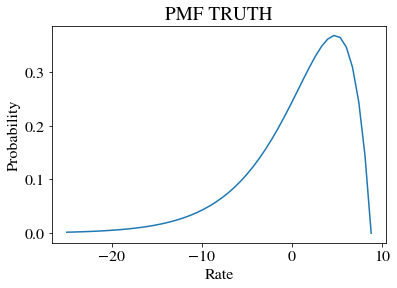

In [1276]:
rates_range = np.linspace(-25, 8.8, 50)
plt.figure()
plt.plot(rates_range, scipy.stats.poisson.pmf(ks, m_truth*rates_range+b_truth))
plt.title('PMF TRUTH')
plt.xlabel('Rate')
plt.ylabel('Probability')
plt.show()

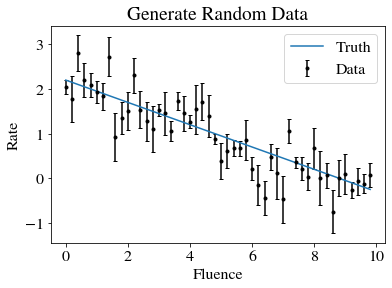

In [1308]:
np.random.seed(123)

N = 50
x = fluences_truth
y = rates_truth* np.random.rand(1)
# x = np.sort(10*np.random.rand(N))
# yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_truth * x + b_truth
y += yerr * np.random.randn(N)

plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=2, label='Data')
plt.plot(fluences_truth, rates_truth, label='Truth')
plt.legend()
plt.xlabel('Fluence')
plt.ylabel('Rate')
plt.title('Generate Random Data')
plt.show()

In [1315]:
def log_likelihood(pars, D, F): # Poisson likelihood
    m, b = pars
    theta = F*m + b
    P = (theta**D * np.exp(-theta)) / D
    return np.sum(np.log(P))



nll = lambda *args: -log_likelihood(*args) 
# maximizing the likelihood is the same as minimizing the negative of the liklihood

initial = np.array([m_truth, b_truth]) + 0.2 * np.random.randn(2)
print(initial)
soln = minimize(nll, initial, args=(ks, x))
m_ml, b_ml = soln.x # maximum likelihood values

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))

[-0.1829398   1.97428895]
Maximum likelihood estimates:
m = -0.000
b = 1.000


In [1311]:
def log_prior(pars): # sets up priors on theta
    m, b = pars
    if -5 < m < 5 and -5 < b < 10:
        return 0.0
    return -np.inf



def log_probability(pars, D, F):
    lp = log_prior(pars) 
    if not np.isfinite(lp): 
        return -np.inf
    if np.isnan(lp + log_likelihood(pars, D, F)):
        return -np.inf
    return lp + log_likelihood(pars, D, F)



pos = soln.x + 1e-2 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim, 
                                log_probability, 
                                args=(ks, x))

sampler.run_mcmc(pos, 7000, progress=True);

/tmp/ipykernel_1128/1099916831.py:5: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(P))
  0%|                                    | 0/7000 [00:00<?, ?it/s]/home/darbymccauley/.local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████| 7000/7000 [00:14<00:00, 475.07it/s]


In [1312]:
samples = sampler.get_chain()

tau = sampler.get_autocorr_time()
print('Integrated autocorrelation time:', tau)

Integrated autocorrelation time: [nan nan]


/home/darbymccauley/.local/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


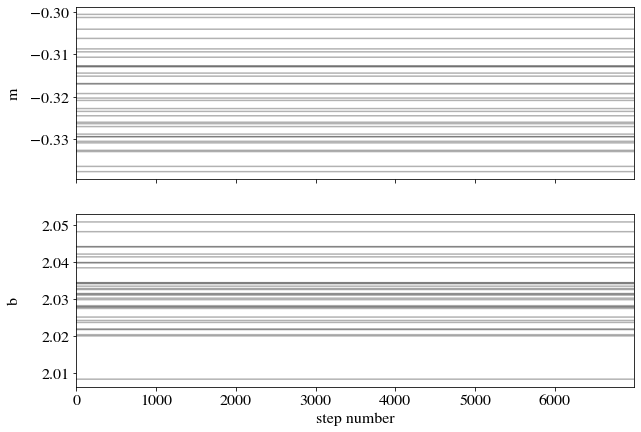

In [1313]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ['m', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples)-1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('step number');

In [1296]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)
print(flat_samples.shape)

(7840, 2)


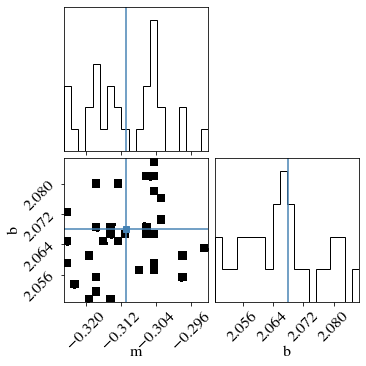

In [1297]:
fig = corner.corner(flat_samples, labels=labels, truths=initial)